## EOSC510: Assignment 3
### Henry Crawford
#### Note: Please do apply PCA on the data (problem 2) first and then perform clustering (hierarchical clustering and SOM) on the first few modes only. Most likely the first 3 modes will be enough to keep.
#### In the final plots, make sure that you reconstruct the data (streamflow) from the clustered PC modes, as was done in the Tutorial example on SST dataset.

In [1]:
# from matplotlib.colors import BoundaryNorm, ListedColormap


#visualize clusters in data-space

from matplotlib import cm
from matplotlib.colors import BoundaryNorm, ListedColormap

fig, ax = plt.subplots(figsize = (8,6))

#colours
cmap = ListedColormap(bmus_colours)
bounds = np.arange(N_nodes+1)-0.5
norm = BoundaryNorm(bounds, cmap.N)

plot_prov_ax(['AB', 'BC'], ax)
sp = ax.scatter(stationLon, stationLat, s = 75, zorder = 5, c = bmus, edgecolor = 'k', cmap = cmap, norm = norm) #observations, coloured by BMU
ax.set_xlabel('x') 
ax.set_ylabel('y')
ax.set_ylim(top = 57)
ax.set_xlim(left = -136)
cb = plt.colorbar(sp)
cb.set_ticks(np.arange(N_nodes))
ax.set_title('Clusters in space')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

NameError: name 'plt' is not defined

In [2]:
# load libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from minisom import MiniSom

savefigs = 0

## Problem 2

In [3]:
# read in and inspect data
data_raw = pd.read_csv('data_problem2.csv', header = None)
lon = pd.read_csv('stationLon.csv', header = None)
lat = pd.read_csv('stationLat.csv', header = None)

print(lon.head())
print(np.shape(data_raw))
data_raw.head()

        0
0 -113.95
1 -114.41
2 -114.13
3 -114.14
4 -114.42
(194, 365)


,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,-0.77209,-0.77209,-0.77209,-0.77209,-0.77209,-0.77209,-0.77209,-0.77209,-0.77209,-0.77209,...,-0.77209,-0.77209,-0.77209,-0.77209,-0.77209,-0.77209,-0.77209,-0.77209,-0.77209,-0.77209
1,-0.68687,-0.68739,-0.68789,-0.68843,-0.68792,-0.68774,-0.68771,-0.68805,-0.68781,-0.68809,...,-0.66194,-0.66250,-0.66291,-0.66406,-0.66509,-0.66627,-0.66736,-0.66834,-0.66970,-0.67129
2,-0.65590,-0.65640,-0.65731,-0.65869,-0.65991,-0.66106,-0.66245,-0.66375,-0.66464,-0.66565,...,-0.67197,-0.67365,-0.67402,-0.67338,-0.67295,-0.67399,-0.67429,-0.67413,-0.67237,-0.67044
3,-0.61866,-0.61911,-0.61960,-0.62028,-0.62031,-0.61999,-0.61950,-0.61933,-0.61912,-0.61894,...,-0.57704,-0.57777,-0.57830,-0.57940,-0.58060,-0.58200,-0.58354,-0.58466,-0.58556,-0.58651
4,-0.64304,-0.64304,-0.64304,-0.64304,-0.64304,-0.64304,-0.64304,-0.64304,-0.64304,-0.64304,...,-0.64304,-0.64304,-0.64304,-0.64304,-0.64304,-0.64304,-0.64304,-0.64304,-0.64304,-0.64304


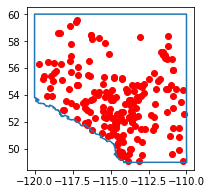

In [4]:
# read in map boundries
ABlon = pd.read_csv('ABLon.csv', header = None)
ABlat = pd.read_csv('ABLat.csv', header = None)

plt.figure(figsize=(3,3))
plt.plot(ABlon, ABlat)
plt.scatter(lon, lat, color = 'r')

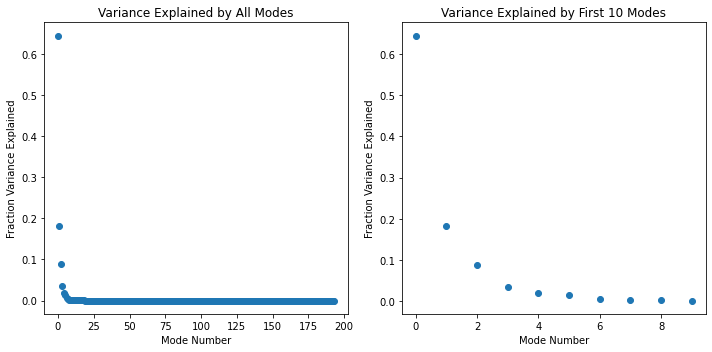

In [5]:
#do PCA
# n - 194, so are we compressing the number of streams? i.e. 194

n_modes = np.min(np.shape(data_raw))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data_raw)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

#plot fraction of variance explained by each mode
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

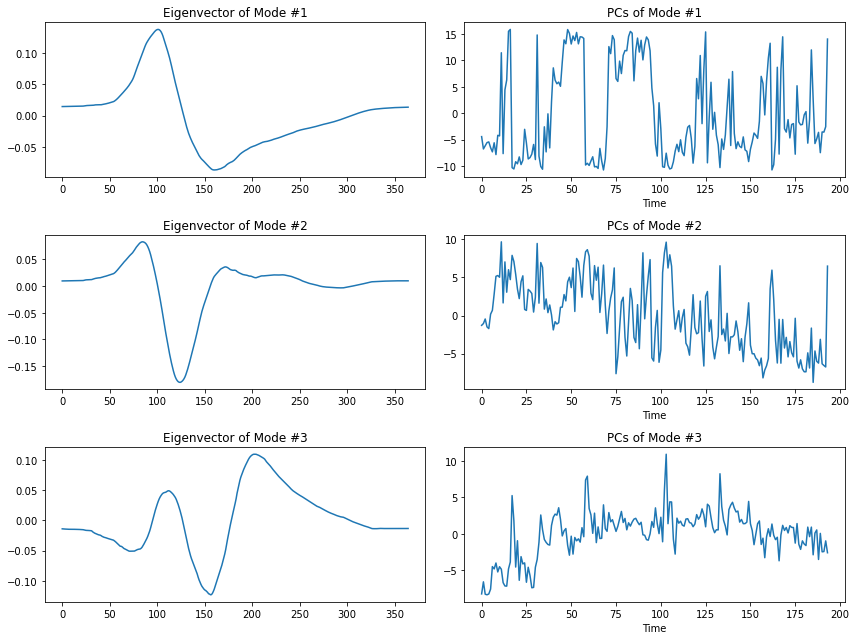

In [7]:
#plot the first n modes and PCs
n = 3

plt.figure(figsize=(12,3*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.plot(eigvecs[kk,:])
    plt.title('Eigenvector of Mode #' + str(kk+1))
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Time')
    
    plt.tight_layout()

In [8]:
tot_var = round((fracVar[0] + fracVar[1] + fracVar[2]) * 100, 1)

tot_var

91.4

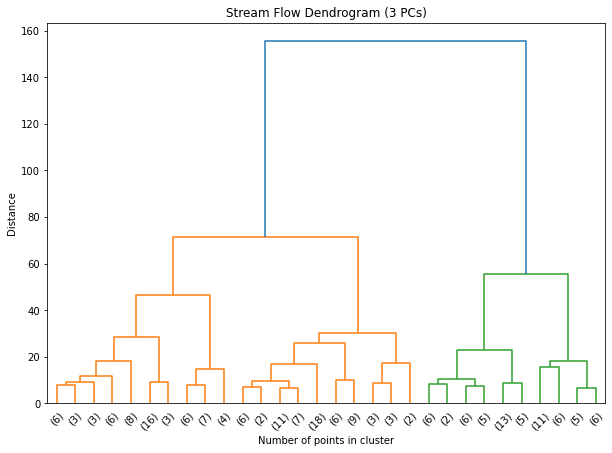

In [11]:
#perform clustering in the space of the first n PCs
n = 3

data_PC = PCs[:,:n]
linked = linkage(data_PC, method = 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, 
           orientation='top', 
           distance_sort='descending',
           truncate_mode='lastp',
           p=30)

plt.xlabel('Number of points in cluster')
plt.ylabel('Distance')
plt.title('Stream Flow Dendrogram (3 PCs)')
plt.show()

In [12]:
# PRETTY SURE THIS SHOULD NOT BE DONE..., if not them use 'data_raw' and add .iloc  after np.squeeze in the following cell

# reconstruct data from first 3 PCs
pca = PCA(n_components= 3)
PCs = pca.fit_transform(data_raw)
y_rec = pca.inverse_transform(PCs)

In [13]:
#now cluster, THIS IS BASED ON Y_REC PCA DATA!!!
n_clusters = 4
cluster = AgglomerativeClustering(n_clusters=n_clusters, 
                                  affinity='euclidean', 
                                  linkage='ward')
cn = cluster.fit_predict(y_rec)

#find mean pattern of each cluster
cluster_pattern_PC = np.empty((n_clusters,np.shape(data_PC)[1])) # empty array for PC-based cluster
cluster_pattern = np.empty((n_clusters,np.shape(y_rec)[1])) # empty array for raw data cluster
for cluster_num in range(n_clusters):
    inds = np.argwhere(cn==cluster_num)
    cluster_pattern_PC[cluster_num,:] = np.mean(data_PC[inds,:],axis=0) # PC-based clusters
    cluster_pattern[cluster_num,:] = np.mean(y_rec[np.squeeze(inds),:],axis=0) # PC reconstructed data clusters

Text(0.5, 1.0, 'Clusters in PC-Space')

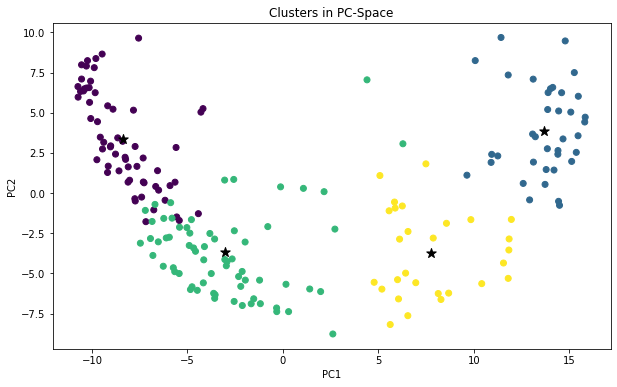

In [14]:
#visualize clusters in PC-space

plt.figure(figsize=(10,6))

plt.subplot(111)
plt.scatter(PCs[:,0],PCs[:,1],c=cn)
plt.scatter(cluster_pattern_PC[:,0],cluster_pattern_PC[:,1],marker='*',c='k',s=100)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('Clusters in PC-Space')


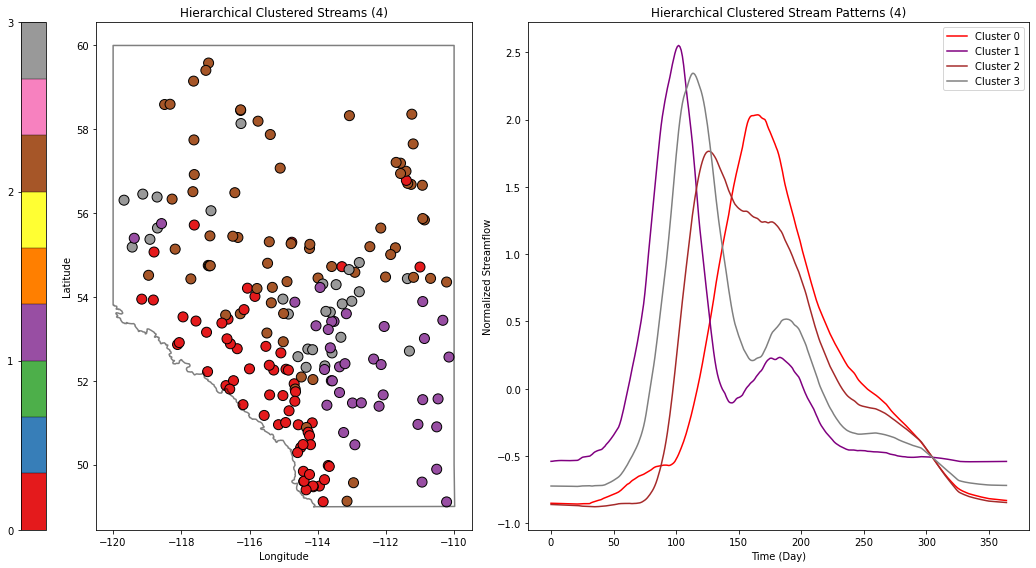

In [15]:
# HOW??? reconstruct the data (streamflow) from the clustered PC modes, as was done in the Tutorial example on SST dataset???.
# Here, the mapped clusters are from PCs, but the clustered daily streamflow is from the raw data clusters, plotting the PC version only gives 3 time steps.
# why are they already averaged in plot 2...
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

#spatial clusters
plt.subplot(121)
plt.plot(ABlon, ABlat,'k', alpha = .5)
plt.scatter(lon, lat,
            #c = eigvecs[kk,:],
            c = cn,
            cmap = 'Set1',
            edgecolor='k',
            s = 100,
            alpha = 1)
            #vmin = -0.4,
            #vmax = 0.4)
            
kwargs = {"drawedges":True,
         "ticks": [0,1,2,3]}

plt.colorbar(**kwargs, location = 'left')

plt.title('Hierarchical Clustered Streams ({})'.format(n_clusters))
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Normalized streams
plt.subplot(122)
plt.plot(cluster_pattern[0].T, c = 'red') 
plt.plot(cluster_pattern[1].T, c = 'purple')
plt.plot(cluster_pattern[2].T, c = 'brown')
plt.plot(cluster_pattern[3].T, c = 'grey')


# USe cluster_pattern_PC.T for PC trasnformed, but only 3 time steps
plt.xlabel('Time (Day)')
plt.ylabel('Normalized Streamflow')
plt.title('Hierarchical Clustered Stream Patterns ({})'.format(n_clusters))
plt.legend(['Cluster ' + str(ii) for ii in range(n_clusters)])

plt.tight_layout()
plt.show()

## SOM

In [16]:
%run C:/Users/htccr/OneDrive/UBC/Coursework/EOSC510/Assignment/Assignment_3/som_class.ipynb

In [17]:
np.shape(data_PC)

(194, 3)

In [45]:
#run SOM -- this code creates/trains the SOM and calculates stats of interest

obs = np.array(y_rec)#

#define constants
Nx = 3
Ny = 2
N_nodes = Nx*Ny
N_obs = np.shape(obs)[0] #number of observations 
N_dims = np.shape(obs)[1] #number of dimensions per observation
learning_rate = 1e-2
N_epochs = 100
colours_list = 'pink_blue_red_purple'
colours_list = 'pinks'
colours_list = 'default2'

#initialize
som = SOM(Nx, Ny, obs, N_epochs, linewidth = 4, colours_list = colours_list)
som.initialize_map(node_shape = 'rect')

#train
som.train_map(learning_rate)
z = som.z #this is the pattern of each BMU
z_epochs = som.z_epochs #this is the pattern of each BMU through training (each epoch)
bmus = BMUs(som) #bmu of each observation
freq = BMU_frequency(som) #frequency of each bmu
dummy,bmus_colours = colourmap_2D(colours_list = colours_list, Nx = Nx, Ny = Ny) #colours of each bmu, for plotting
QE = som.QE() #quantization error of map
TE = som.TE() #topographic error of map

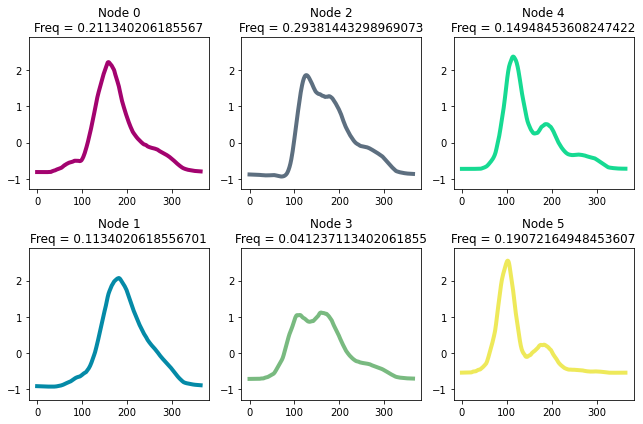

In [46]:
#fig, axes = som.plot() #this is the som class implementation of plotting

#this is the raw code which produces the above -- feel free to play around with this to customize

border = 0.1*(np.max(som.z) - np.min(som.z)) #how much space above / below max/min values to have in subplots
indices = np.arange(N_nodes).reshape(Nx,Ny).T.flatten()
dummy,bmus_colours = colourmap_2D(colours_list = som.colours_list, Nx = Nx, Ny = Ny)

fig, axes = plt.subplots(nrows = Ny, ncols = Nx, figsize = (3*Nx, 3*Ny))

for kk, ax in enumerate(axes.flatten()): #for each axis (subplot)
    var = z[indices[kk],:]
    ax.plot(var, color = bmus_colours[indices[kk],:], linewidth = 4)
    ax.set_ylim(bottom = np.min(z)-border, top = np.max(z)+border)
    ax.set_title('Node ' + str(indices[kk]) + '\nFreq = ' + str(BMU_frequency(som)[indices[kk]]))

plt.tight_layout()

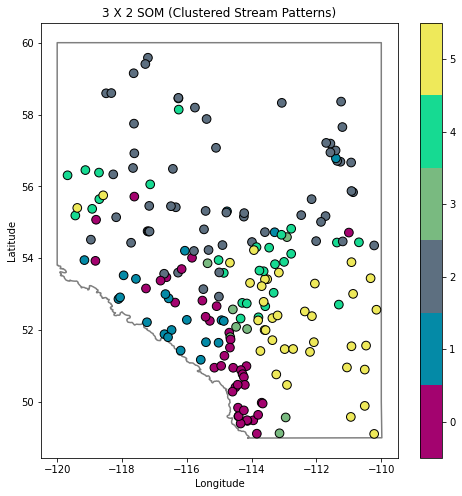

In [47]:
#visualize clusters in data-space
from matplotlib import cm
from matplotlib.colors import BoundaryNorm, ListedColormap

fig, ax = plt.subplots(figsize = (8,8))

#colours
cmap = ListedColormap(bmus_colours)
bounds = np.arange(N_nodes+1)-0.5
norm = BoundaryNorm(bounds, cmap.N)

plt.plot(ABlon, ABlat,'k', alpha = .5)
sp = ax.scatter(lon, lat, s = 75, zorder = 5, c = bmus, edgecolor = 'k', cmap = cmap, norm = norm) #observations, coloured by BMU
ax.set_xlabel('x') 
ax.set_ylabel('y')
#ax.set_ylim(top = #)
#ax.set_xlim(left = #)
cb = plt.colorbar(sp)
cb.set_ticks(np.arange(N_nodes))
plt.title('{} X {} SOM (Clustered Stream Patterns)'.format(Nx,Ny))
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

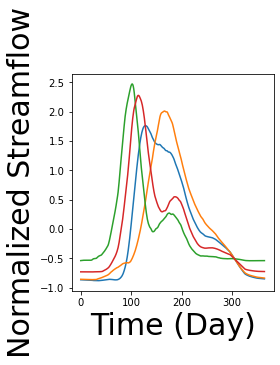

In [43]:
plt.figure(figsize = (4,4))

plt.plot(z.T, ) 
plt.xlabel('Time (Day)', size = 30)
plt.ylabel('Normalized Streamflow', size = 30)


plt.tight_layout()
plt.show()